In [1]:
spatialSample="spider" #p16 or spider. Key.

In [2]:
#Detect GPU.

import subprocess
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception:
    print('No Nvidia GPU detected!')

Nvidia GPU detected!


In [3]:
#Detect GPU.

import torch
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached: ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
else:
    print("GPU is not available")
    device = torch.device("cpu")

#FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`.

GPU is available
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:  0.0 GB


/tmp/ipykernel_3887005/4139710248.py:10: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached: ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


In [4]:
import scanpy as sc
import numpy as np
import cell2location

#This takes a few minutes.

#SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
#SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [5]:
results_folder=f"/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_spatialCellTypes/1.5_resultCell2location/{spatialSample}/" #No need to create these folders in advance.

#Create paths to results folders for reference regression and cell2location models.
ref_run_name=f"{results_folder}/reference_signatures"
run_name=f"{results_folder}/cell2location_map"

In [6]:
adata_vis=sc.read_h5ad(f"/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_prepareData/_Data/dataSpatial_{spatialSample}.h5ad")
adata_ref=sc.read_h5ad("/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_prepareData/_Data/dataSnRNASeq.h5ad")

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


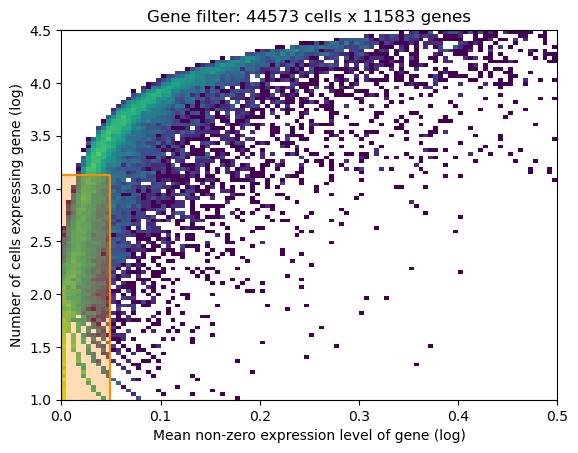

In [7]:
#Perform gene selection.
from cell2location.utils.filtering import filter_genes
selected=filter_genes(adata_ref,
                      cell_count_cutoff=5,cell_percentage_cutoff2=0.03,nonz_mean_cutoff=1.12) #11,583 genes selected.

#RuntimeWarning: divide by zero encountered in log10.

In [8]:
#Filter the object.
adata_ref=adata_ref[:,selected].copy()

In [9]:
adata_ref

AnnData object with n_obs × n_vars = 44573 × 11583
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'celltype'
    var: 'names', 'n_cells', 'nonz_mean'

In [10]:
#Cast sparse matrix as CSR.
from scipy.sparse import csr_matrix
adata_ref.X=csr_matrix(adata_ref.X)

#Estimate reference cell type signatures (NB regression).
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                                                   batch_key="sample", #10X reaction/sample/batch.
                                                   labels_key="celltype" #Cell type, covariate used for constructing signatures.
                                                  )

#If I don't cast sparse matrix as CSR:
#UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.

In [11]:
adata_ref

AnnData object with n_obs × n_vars = 44573 × 11583
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'celltype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'names', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [12]:
adata_ref.obs

,nCount_RNA,nFeature_RNA,percent.mt,sample,celltype,_indices,_scvi_batch,_scvi_labels
AAACAGCCAAACATAG-1,2972.0,1738,2.254374,SN3_1,Fibroblasts,0,2,4
AAACAGCCAACTAGAA-4,3373.0,1812,0.859769,MI_4,Endothelial cells,1,1,2
AAACAGCCAACTCGCG-1,1410.0,1006,0.141844,SN3_1,Immune-T cells,2,2,6
AAACAGCCAAGGTATA-2,3021.0,2049,0.264813,SN3_2,Endothelial cells,3,3,2
AAACAGCCAAGGTCGA-2,2670.0,1740,0.411985,SN3_2,Fibroblasts,4,3,4
...,...,...,...,...,...,...,...,...
TTTGTTGGTGTGCACG-3,2738.0,1297,1.533966,MI_1,Fibroblasts,44568,0,4
TTTGTTGGTTAATGAC-2,5044.0,2058,0.118953,SN3_2,Cardiomyocytes,44569,3,0
TTTGTTGGTTACTTCA-1,3772.0,2131,0.450689,SN3_1,Fibroblasts,44570,2,4
TTTGTTGGTTAGTACG-2,2082.0,1325,0.288184,SN3_2,Fibroblasts,44571,3,4


In [13]:
adata_ref.uns

OrderedDict([('_scvi_uuid', 'ca8b3496-3450-4482-984d-c610cff9150c'),
             ('_scvi_manager_uuid', '559d6ed8-344a-4a4d-a0bc-074442bc6a59')])

In [14]:
#Create the regression model.
from cell2location.models import RegressionModel
mod=RegressionModel(adata_ref)

In [15]:
#View anndata_setup as a sanity check.
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 44573 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  10   │
│          n_vars          │ 11583 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │    MI_1    │          0          │
│                     │    MI_4    │          1          │
│                     │   SN3_1    │          2          │
│                     │   SN3_2    │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                        labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃     Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │   Cardiomyocytes    │          0          │
│                       │   Dentritic cells   │          1          │
│                       │  Endothelial cells  │          2          │
│                       │  Epicardial cells   │          3          │
│                       │     Fibroblasts     │          4          │
│                       │   Immune-B cells    │          5          │
│                       │   Immune-T cells    │          6          │
│                       │     Macrophages     │          7          │
│                       │      Pericytes      │          8          │
│                       │ Smooth muscle cells │          9          │
└───────────────────────┴─────────────────────┴─────────────────────┘

In [16]:
#Key step.
mod.train(max_epochs=250)

#This takes about 10 minutes.

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed 

Training:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


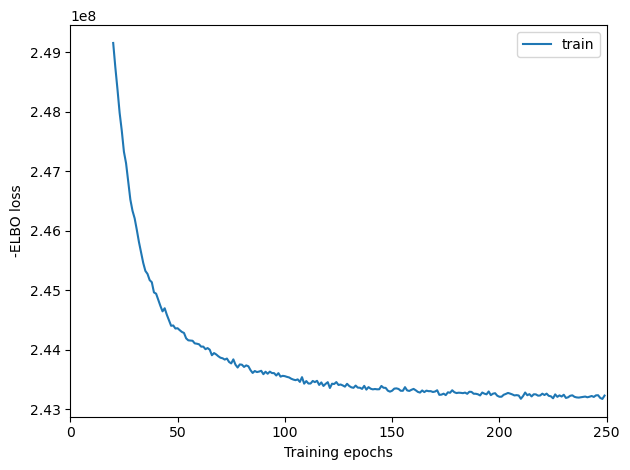

In [17]:
mod.plot_history(20) #Omit the first 20 epochs from the plot.

In [18]:
#Export the estimated cell abundance (summary of the posterior distribution).
adata_ref=mod.export_posterior(adata_ref,sample_kwargs={"num_samples":1000,"batch_size":2500})

#Save model.
mod.save(f"{ref_run_name}",overwrite=True)

#Save anndata object with results.
adata_file=f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...


Sampling local variables, batch:   0%|          | 0/18 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_spatialCellTypes/1.5_resultCell2location/spider//reference_signatures/sc.h5ad'

In [19]:
adata_ref

AnnData object with n_obs × n_vars = 44573 × 11583
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample', 'celltype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'names', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'stds_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg'

In [20]:
adata_ref.varm["q05_per_cluster_mu_fg"]

,q05_per_cluster_mu_fg_Cardiomyocytes,q05_per_cluster_mu_fg_Dentritic cells,q05_per_cluster_mu_fg_Endothelial cells,q05_per_cluster_mu_fg_Epicardial cells,q05_per_cluster_mu_fg_Fibroblasts,q05_per_cluster_mu_fg_Immune-B cells,q05_per_cluster_mu_fg_Immune-T cells,q05_per_cluster_mu_fg_Macrophages,q05_per_cluster_mu_fg_Pericytes,q05_per_cluster_mu_fg_Smooth muscle cells
Xkr4,0.008995,0.157890,0.144671,1.060849,1.236461,0.074742,0.086469,0.125245,0.196084,0.367056
Gm19938,0.000149,0.000829,0.004209,0.035221,0.040786,0.004109,0.001096,0.004318,0.001937,0.010093
Sox17,0.000238,0.018355,0.208543,0.026217,0.003495,0.009304,0.011177,0.001576,0.014304,0.022300
Mrpl15,0.073790,0.061905,0.067182,0.088253,0.062412,0.026987,0.026144,0.050175,0.053083,0.046735
Lypla1,0.218156,0.187008,0.292380,0.355140,0.239186,0.185251,0.227765,0.213866,0.209526,0.221647
...,...,...,...,...,...,...,...,...,...,...
mt-Cytb,0.827847,2.003737,4.398685,8.078248,2.459363,0.999539,1.682974,1.710057,1.733935,4.741142
CAAA01118383.1,0.122653,0.181494,0.150328,0.280587,0.143870,0.112241,0.097709,0.168322,0.112475,0.165240
Vamp7,0.020915,0.023697,0.048307,0.080428,0.064179,0.032949,0.040655,0.043903,0.034801,0.032780
Tmlhe,0.311120,0.084223,0.342044,0.608848,0.402510,0.080407,0.249003,0.319918,0.318567,0.366938


In [21]:
np.sum(adata_ref.varm["q05_per_cluster_mu_fg"],axis=1)

Xkr4               3.458462
Gm19938            0.102747
Sox17              0.315510
Mrpl15             0.556665
Lypla1             2.349924
                    ...    
mt-Cytb           28.635527
CAAA01118383.1     1.534918
Vamp7              0.422612
Tmlhe              3.083578
AC149090.1         5.187081
Length: 11583, dtype: float32

In [22]:
np.sum(adata_ref.varm["q05_per_cluster_mu_fg"],axis=0)

q05_per_cluster_mu_fg_Cardiomyocytes         4113.291016
q05_per_cluster_mu_fg_Dentritic cells        2842.539795
q05_per_cluster_mu_fg_Endothelial cells      2990.491699
q05_per_cluster_mu_fg_Epicardial cells       4755.992188
q05_per_cluster_mu_fg_Fibroblasts            3274.739502
q05_per_cluster_mu_fg_Immune-B cells         1586.190796
q05_per_cluster_mu_fg_Immune-T cells         2025.030029
q05_per_cluster_mu_fg_Macrophages            2730.426025
q05_per_cluster_mu_fg_Pericytes              2714.921875
q05_per_cluster_mu_fg_Smooth muscle cells    3248.900879
dtype: float32

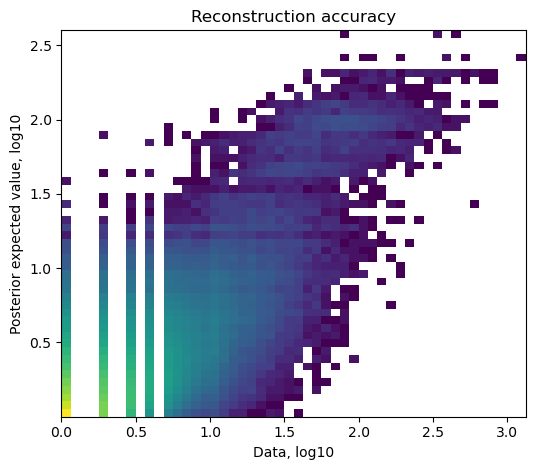

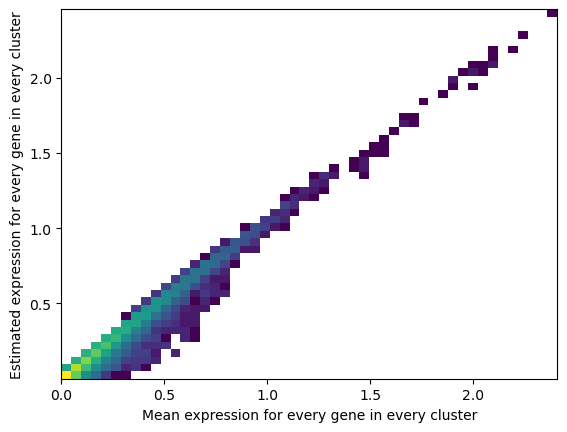

In [23]:
mod.plot_QC()

In [24]:
#Export estimated expression in each cluster.
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver=adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                                        for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver=adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                            for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns=adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5,0:5]

,Cardiomyocytes,Dentritic cells,Endothelial cells,Epicardial cells,Fibroblasts
Xkr4,0.013717,0.225769,0.157577,1.216538,1.297877
Gm19938,0.001196,0.005906,0.006181,0.049447,0.044375
Sox17,0.001277,0.037022,0.221500,0.038787,0.004599
Mrpl15,0.088613,0.092042,0.072949,0.110169,0.066858
Lypla1,0.243961,0.245380,0.306996,0.399070,0.248650


In [25]:
#Find shared genes and subset both anndata and reference signatures.
intersect=np.intersect1d(adata_vis.var_names,inf_aver.index)
adata_vis=adata_vis[:,intersect].copy()
inf_aver=inf_aver.loc[intersect,:].copy()

In [26]:
#Cast sparse matrix as CSR.
adata_vis.X=csr_matrix(adata_vis.X)

#Prepare anndata for cell2location model.
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)

#If I don't cast sparse matrix as CSR:
#UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.

In [27]:
#Create the model.
mod=cell2location.models.Cell2location(
    adata_vis,cell_state_df=inf_aver, #The expected average cell abundance: tissue-dependent.
    N_cells_per_location=10, #Hyper-prior which can be estimated from paired histology.
    detection_alpha=20 #Hyperparameter controlling normalisation of within-experiment variation in RNA detection.
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 1420  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10376 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [28]:
#Train the model.
mod.train(max_epochs=30000,
          batch_size=None, #Train using full data. Use all data points in training because we need to estimate cell abundance at all locations.
          train_size=1
         )

#This takes about 30 minutes.

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...
/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed 

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30000` reached.


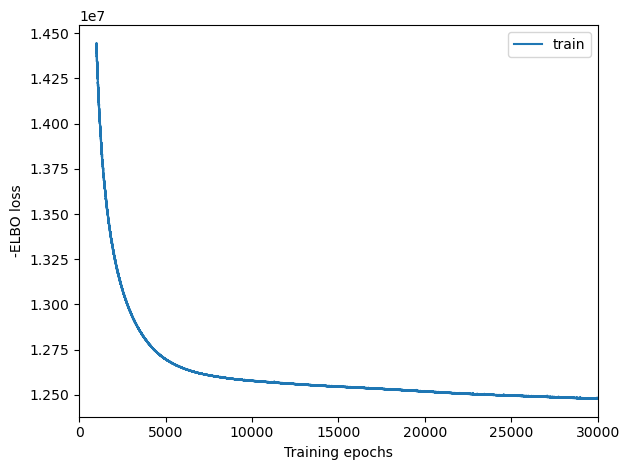

In [29]:
mod.plot_history(1000) #Omit the first 1000 epochs from the plot.

In [30]:
#Export the estimated cell abundance (summary of the posterior distribution).
adata_vis=mod.export_posterior(adata_vis,sample_kwargs={"num_samples":1000,"batch_size":mod.adata.n_obs})

#Save model.
mod.save(f"{run_name}",overwrite=True)

#Save anndata object with results.
adata_file=f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/home/hezhou/_Programs/anaconda3/envs/cell2loc_env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.12 /home/hezhou/_Programs/anaconda3/envs/cell2loc_e ...


Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

'/home/hezhou/_Projects/25.02.27_Jielin_Senescence/25.04.07_spatialCellTypes/1.5_resultCell2location/spider//cell2location_map/sp.h5ad'

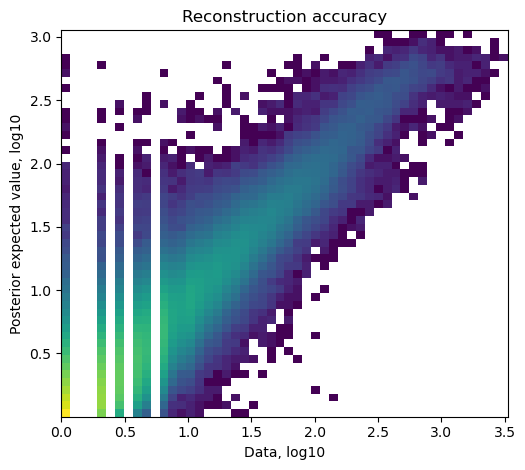

In [31]:
mod.plot_QC()

In [32]:
adata_vis

AnnData object with n_obs × n_vars = 1420 × 10376
    obs: 'nCount_Spatial', 'nFeature_Spatial', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'names'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

In [33]:
adata_vis.obsm["q05_cell_abundance_w_sf"] #We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka ‘at least this amount is present’).

,q05cell_abundance_w_sf_Cardiomyocytes,q05cell_abundance_w_sf_Dentritic cells,q05cell_abundance_w_sf_Endothelial cells,q05cell_abundance_w_sf_Epicardial cells,q05cell_abundance_w_sf_Fibroblasts,q05cell_abundance_w_sf_Immune-B cells,q05cell_abundance_w_sf_Immune-T cells,q05cell_abundance_w_sf_Macrophages,q05cell_abundance_w_sf_Pericytes,q05cell_abundance_w_sf_Smooth muscle cells
AACACGTTGATACCGC-1,7.092840,0.001504,0.630062,0.049933,0.428709,0.007359,0.014145,0.070031,0.004158,0.000378
AACAGGCCATTGTCAC-1,4.438040,0.011908,0.511463,0.079010,0.164126,0.000523,0.009911,0.095136,0.104484,0.001126
AACATACTAGCCGAAG-1,6.143573,0.102080,0.675731,0.000143,0.000381,0.002226,0.001803,0.064863,0.004895,0.001362
AACATACTCCACAGTT-1,6.161401,0.000142,0.517766,0.012660,0.522268,0.000417,0.000665,0.001016,0.429467,0.004891
AACATATGCACTTCTA-1,0.000020,0.018861,0.013604,1.690346,8.650589,0.002396,0.002710,1.685961,0.017804,0.014431
...,...,...,...,...,...,...,...,...,...,...
TGTTCGTGGCGTCGTG-1,8.981681,0.010665,0.478343,0.366188,3.005565,0.004044,0.011122,0.383249,0.037748,0.006536
TGTTGCCAGTCGCCTG-1,5.096293,0.000295,0.229588,0.008665,0.020734,0.001339,0.010039,0.024368,0.120915,0.003120
TGTTGGCCTGTAGCGG-1,0.000120,0.020620,0.010093,2.120713,9.697272,0.002314,0.002964,1.372842,0.069753,0.023674
TGTTGGTGCGGAATCA-1,5.209109,0.000245,0.462447,0.135144,0.402331,0.000361,0.027380,0.136754,0.241222,0.008494


In [34]:
np.sum(adata_vis.obsm["q05_cell_abundance_w_sf"],axis=1)

AACACGTTGATACCGC-1     8.299119
AACAGGCCATTGTCAC-1     5.415726
AACATACTAGCCGAAG-1     6.997056
AACATACTCCACAGTT-1     7.650691
AACATATGCACTTCTA-1    12.096722
                        ...    
TGTTCGTGGCGTCGTG-1    13.285140
TGTTGCCAGTCGCCTG-1     5.515357
TGTTGGCCTGTAGCGG-1    13.320365
TGTTGGTGCGGAATCA-1     6.623487
TGTTGGTGGACTCAGG-1     6.159115
Length: 1420, dtype: float32

In [35]:
adata_vis.obsm["q05_cell_abundance_w_sf"].to_csv(f"{results_folder}/{spatialSample}.csv")